# Outlier Detection (Hard)

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This task involves locating the input element with the largest minimum Euclidean distance to any other point, out of a set $\left\lbrace x_1, \dots, x_L \right\rbrace \subseteq \mathbb{R}^N$ of varying size $L$.

$$
\max_{i} \left( \min_{j \neq i} \left\Vert x_i - x_j \right\Vert_2 \right)
$$

It is easy to compute the answer without any model:

In [2]:
from typing import Optional

from torch import Tensor

def is_outlier(
        x: Tensor,
        mask: Optional[Tensor] = None,
) -> Tensor:
    B = x.shape[:-2]
    L, I = x.shape[-2:]
    distances = (x.unsqueeze(-2) - x.unsqueeze(-3)).norm(dim=-1)
    assert isinstance(distances, Tensor)
    assert distances.shape == (*B, L, L)
    i = torch.arange(L, device=device)
    distances[...,i,i] = torch.inf

    if mask is not None:
        assert mask.shape == (*B, L)
        pair_mask = mask.unsqueeze(-1) & mask.unsqueeze(-2)
        distances = torch.where(pair_mask, distances, torch.inf)

    min_distances = distances.min(dim=-1).values
    assert isinstance(min_distances, Tensor)
    assert min_distances.shape == (*B, L)
    
    if mask is not None:
        min_distances = torch.where(mask, min_distances, -torch.inf)

    furthest = min_distances.max(dim=-1, keepdim=True).values
    assert isinstance(furthest, Tensor)
    assert furthest.shape == (*B, 1)
    outlier = (min_distances == furthest)
    assert outlier.shape == (*B, L)
    return outlier

The task is evaluated using precision:

In [3]:
def get_precision(
        target: Tensor,
        prediction: Tensor,
) -> float:
    assert target.dtype == prediction.dtype == torch.bool
    B = target.shape[:-1]
    L = target.shape[-1]
    assert prediction.shape == (*B, L)
    correct = (target & prediction).sum(dim=-1).float()
    predicted = prediction.sum(dim=-1).float()
    assert correct.shape == predicted.shape == B
    precision = correct / predicted.clamp_min(1.0)
    return float(precision.mean())

## Data

During training, the data generation process is as follows:

- sample a length $L$ uniformly from $3$ to $L_\mathrm{max}$ inclusive
- sample a mean $\mu \in \mathbb{R}^N \sim \mathcal{N}(0,I)$
- sample $x_1, \dots, x_L \sim \mathcal{N}(\mu,I)$

The purpose of the mean is to ensure that the model does not falsely use distance from the origin as a proxy.

For these experiments we use $L_\mathrm{max} = 100$.

During evaluation, we evalute $1000$ times for each value of $L$ from $2$ to $2 L_\mathrm{max}$ and plot the accuracy curve.

In [4]:
from torch import Tensor

def get_uniform_batch(
        *,
        length: int,
        input_dim: int,
        batch_size: int,
        rng: torch.Generator,
        device: torch.device = device,
) -> Tensor:
    B = batch_size
    L = length
    I = input_dim
    mean = torch.randn((B, I), generator=rng, device=device)
    x = torch.randn((B, L, I), generator=rng, device=device)
    x = x + mean.unsqueeze(dim=-2)
    return x

L_max = 100

def get_mixed_batch(
        *,
        input_dim: int,
        batch_size: int,
        max_length: int = L_max,
        rng: torch.Generator,
        device: torch.device = device,
) -> tuple[Tensor, Tensor]:
    B = batch_size
    I = input_dim

    length = torch.randint(
        low=3,
        high=max_length + 1,
        size=(B,),
        generator=rng,
        device=device,
    )
    L = int(length.max())

    x = get_uniform_batch(
        length=L,
        input_dim=I,
        batch_size=B,
        rng=rng,
        device=device,
    )
    mask = torch.arange(L, device=device).unsqueeze(dim=0) < length.unsqueeze(dim=-1)
    return x, mask

## Model

In [5]:
import torch
from torch import nn, Tensor


class OutlierDetectionModel(nn.Module):
    def __init__(
            self,
            input_dim: int,
            embed_dim: int,
            num_heads: int,
            num_layers: int,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        self.input_ff = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=embed_dim),
            nn.GELU(),
        )
        if num_layers > 0:
            layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                activation="gelu",
                dropout=0.0, # William's advice: use L2 regularization instead
                dim_feedforward=(embed_dim*4),
                norm_first=True,
                batch_first=True,
            )
            self.transformer = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.classification_ff = nn.Linear(
            in_features=embed_dim,
            out_features=1,
            bias=False,
        )

    def forward(
            self,
            elements: Tensor,
            *,
            mask: Optional[Tensor] = None,
    ) -> tuple[Tensor, Tensor]:
        B, L, I = elements.shape
        assert I == self.input_dim

        E = self.embed_dim

        x = self.input_ff(elements)
        assert isinstance(x, Tensor)
        assert x.shape == (B, L, E)

        if self.num_layers > 0:
            if mask is None:
                transformer_mask = None
            else:
                assert mask.shape == (B, L)
                transformer_mask = ~mask
            x = self.transformer(x, src_key_padding_mask=transformer_mask)
            assert isinstance(x, Tensor)
            assert x.shape == (B, L, E)

        logits = self.classification_ff(x)
        assert isinstance(logits, Tensor)
        assert logits.shape == (B, L, 1)
        logits = logits.squeeze(dim=-1)
        assert logits.shape == (B, L)
        if mask is not None:
            logits = torch.where(mask, logits, -torch.inf)
        logits = logits.log_softmax(dim=-1)

        outlier = is_outlier(elements, mask=mask)
        loss = -(logits[outlier].sum())
        return logits, loss


## Experiment

In [6]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

lengths = list(range(1, 2*L_max+1))
random_precision = [1 / l for l in lengths]
random_mean_precision = sum(random_precision) / len(random_precision)

train_steps_per_epoch = 100
train_batch_size = 100
eval_batch_size = 1000
epochs_without_improvement_to_stop = 10

def experiment(
    *,
    input_dim: int,
    embed_dim: int,
    num_heads: int,
    num_layers: int,
    seed: int = 0,
) -> float:
    torch.manual_seed(seed)

    model = OutlierDetectionModel(
        input_dim=input_dim,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers,
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    mean_loss_acc: list[float] = []
    precision_accs: list[list[float]] = []
    mean_precision_acc: list[float] = []
    best_epoch: int = 0
    best_mean_precision: float = 0.0

    train_rng = torch.Generator(device=device).manual_seed(seed)

    epoch = 0
    while True:
        if epoch - best_epoch > epochs_without_improvement_to_stop:
            break

        total_loss = 0.0
        if epoch > 0:
            model.train()
            for i in range(train_steps_per_epoch):
                x, mask = get_mixed_batch(
                    input_dim=input_dim,
                    batch_size=train_batch_size,
                    rng=train_rng,
                )
                _, loss = model(x, mask=mask)
                assert isinstance(loss, Tensor)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                total_loss += float(loss)    
        mean_loss = total_loss / train_steps_per_epoch
        mean_loss_acc.append(mean_loss)

        eval_rng = torch.Generator(device=device).manual_seed(0)
        with torch.no_grad():
            precision_acc: list[float] = []
            model.eval()
            for L in lengths:
                x = get_uniform_batch(
                    length=L,
                    input_dim=input_dim,
                    batch_size=eval_batch_size,
                    rng=eval_rng,
                )
                logits, _ = model(x)
                assert isinstance(logits, Tensor)
                target = is_outlier(x)
                prediction = (logits == logits.max(dim=-1, keepdim=True).values)
                assert isinstance(prediction, Tensor)
                precision = get_precision(target, prediction)
                precision_acc.append(precision)
            precision_accs.append(precision_acc)
            mean_precision = sum(precision_acc) / len(precision_acc)
            mean_precision_acc.append(mean_precision)

            if mean_precision > best_mean_precision:
                best_mean_precision = mean_precision
                best_epoch = epoch

        plt.figure(figsize=(6.0, 6.0))
        e = 1
        plt.plot(lengths, random_precision, label="Random Baseline")
        while e <= epoch:
            plt.plot(lengths, precision_accs[e], label=f"Epoch {e}")
            e *= 2
        plt.plot(lengths, precision_accs[best_epoch], label=f"Best Epoch ({best_epoch})")
        plt.xlabel("Length")
        plt.xlim(0, 2*L_max)
        plt.ylabel("Precision")
        plt.ylim(0.0, 1.0)
        plt.legend()
        clear_output(wait=True)
        for e, (ml, mp) in enumerate(zip(mean_loss_acc, mean_precision_acc)):
            if e == 0:
                continue
            print(
                f"Epoch {e:03d}: mean loss = {ml:.3f} | mean precision = {mp:.3f}"
                + (" (*)" if best_epoch == e else "")
            )
        plt.show()

        epoch += 1

    return best_mean_precision

print(random_mean_precision)

0.02939015474060723


**TODO**: ablations 

Epoch 001: mean loss = 256.234 | mean precision = 0.424
Epoch 002: mean loss = 169.155 | mean precision = 0.466
Epoch 003: mean loss = 155.205 | mean precision = 0.499
Epoch 004: mean loss = 151.359 | mean precision = 0.505
Epoch 005: mean loss = 146.053 | mean precision = 0.525
Epoch 006: mean loss = 140.743 | mean precision = 0.533
Epoch 007: mean loss = 132.908 | mean precision = 0.545
Epoch 008: mean loss = 130.459 | mean precision = 0.558
Epoch 009: mean loss = 127.506 | mean precision = 0.560
Epoch 010: mean loss = 125.812 | mean precision = 0.556
Epoch 011: mean loss = 123.398 | mean precision = 0.559
Epoch 012: mean loss = 122.914 | mean precision = 0.562
Epoch 013: mean loss = 117.532 | mean precision = 0.579
Epoch 014: mean loss = 118.444 | mean precision = 0.583
Epoch 015: mean loss = 115.952 | mean precision = 0.594
Epoch 016: mean loss = 112.787 | mean precision = 0.598
Epoch 017: mean loss = 115.055 | mean precision = 0.590
Epoch 018: mean loss = 111.739 | mean precision 

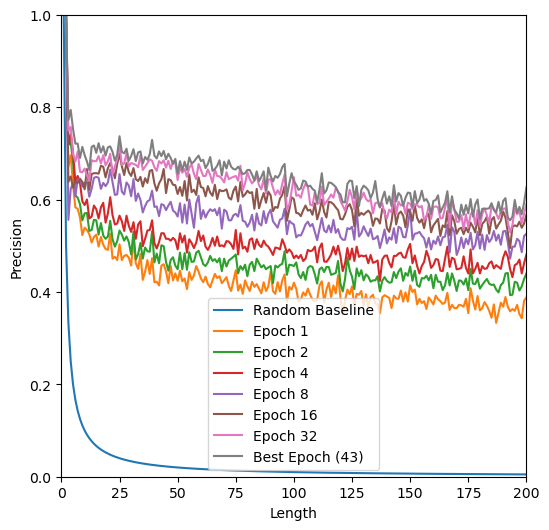

0.6456650310754776

In [7]:
experiment(
    input_dim=4,
    embed_dim=16,
    num_heads=4,
    num_layers=4,
)